# Visualizing Activation from a CNN

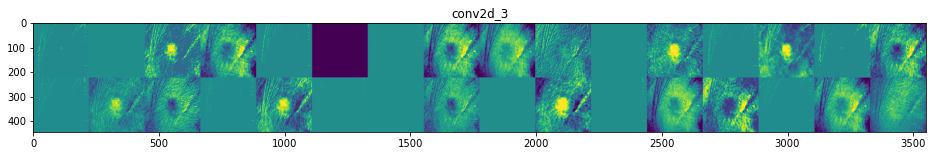

Skin cancer is the most prevalent type of cancer. Melanoma, specifically, is responsible for 75% of skin cancer deaths, despite being the least common skin cancer. The American Cancer Society estimates over 100,000 new melanoma cases will be diagnosed in 2020. It's also expected that almost 7,000 people will die from the disease. As with other cancers, early and accurate detection—potentially aided by data science—can make treatment more effective.

Currently, dermatologists evaluate every one of a patient's moles to identify outlier lesions or “ugly ducklings” that are most likely to be melanoma. Existing AI approaches have not adequately considered this clinical frame of reference. Dermatologists could enhance their diagnostic accuracy if detection algorithms take into account “contextual” images within the same patient to determine which images represent a melanoma. If successful, classifiers would be more accurate and could better support dermatological clinic work.

As the leading healthcare organization for informatics in medical imaging, the Society for Imaging Informatics in Medicine (SIIM)'s mission is to advance medical imaging informatics through education, research, and innovation in a multi-disciplinary community. SIIM is joined by the International Skin Imaging Collaboration (ISIC), an international effort to improve melanoma diagnosis. The ISIC Archive contains the largest publicly available collection of quality-controlled dermoscopic images of skin lesions.

In this competition, you’ll identify melanoma in images of skin lesions. In particular, you’ll use images within the same patient and determine which are likely to represent a melanoma. Using patient-level contextual information may help the development of image analysis tools, which could better support clinical dermatologists.

Melanoma is a deadly disease, but if caught early, most melanomas can be cured with minor surgery. Image analysis tools that automate the diagnosis of melanoma will improve dermatologists' diagnostic accuracy. Better detection of melanoma has the opportunity to positively impact millions of people.

In [27]:
# load libraries
import os
####*IMPORANT*: Have to do this line *before* importing tensorflow
os.environ['PYTHONHASHSEED']=str(1)

import tensorflow as tf
import numpy as np
import random

def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(1)
   tf.random.set_seed(1)
   np.random.seed(1)
   random.seed(1)
    
reset_random_seeds()

from tensorflow import keras
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import models
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

## Load Data

In [28]:
#https://www.kaggle.com/ibtesama/siim-baseline-keras-vgg16
train_dir='/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'
test_dir='/kaggle/input/siim-isic-melanoma-classification/jpeg/test/'
df=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')
test=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/test.csv')
submission=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv')
df.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign       0  
2     nevus           benign       0  
3   unknown           benign       0  
4   unknown           benign       0

In [29]:
test.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge
0  ISIC_0052060  IP_3579794    male        70.0                           NaN
1  ISIC_0052349  IP_7782715    male        40.0               lower extremity
2  ISIC_0058510  IP_7960270  female        55.0                         torso
3  ISIC_0073313  IP_6375035  female        50.0                         torso
4  ISIC_0073502  IP_0589375  female        45.0               lower extremity

In [30]:
df.shape

(33126, 8)

In [31]:
df['image_name'].nunique()

33126

In [32]:
df.groupby('benign_malignant').count()

image_name  patient_id    sex  age_approx  \
benign_malignant                                              
benign                 32542       32542  32477       32474   
malignant                584         584    584         584   

                  anatom_site_general_challenge  diagnosis  target  
benign_malignant                                                    
benign                                    32024      32542   32542  
malignant                                   575        584     584

In [33]:
df.groupby('target').count()

image_name  patient_id    sex  age_approx  \
target                                              
0            32542       32542  32477       32474   
1              584         584    584         584   

        anatom_site_general_challenge  diagnosis  benign_malignant  
target                                                              
0                               32024      32542             32542  
1                                 575        584               584

In [34]:
del df['benign_malignant']

In [35]:
df[df['diagnosis'] == 'unknown']['target'].value_counts()

0    27124
Name: target, dtype: int64

In [36]:
df.shape

(33126, 7)

In [37]:
df = df[df['diagnosis'] != 'unknown']

In [38]:
df.shape

(6002, 7)

In [39]:
df['diagnosis'].value_counts()

nevus                                 5193
melanoma                               584
seborrheic keratosis                   135
lentigo NOS                             44
lichenoid keratosis                     37
solar lentigo                            7
cafe-au-lait macule                      1
atypical melanocytic proliferation       1
Name: diagnosis, dtype: int64

In [40]:
df[(df['diagnosis'] == 'atypical melanocytic proliferation') | (df['diagnosis'] == 'cafe-au-lait macule') | (df['diagnosis'] == 'solar lentigo')]['target']

4176     0
9792     0
9987     0
13765    0
23051    0
24242    0
24485    0
27630    0
30473    0
Name: target, dtype: int64

In [41]:
df = df[~df['diagnosis'].isin(['atypical melanocytic proliferation','cafe-au-lait macule','solar lentigo'])]

In [42]:
df.head()

image_name  patient_id     sex  age_approx  \
2   ISIC_0052212  IP_2842074  female        50.0   
12  ISIC_0076995  IP_2235340  female        55.0   
26  ISIC_0084086  IP_4023055    male        60.0   
27  ISIC_0084270  IP_2961528    male        40.0   
28  ISIC_0084395  IP_0175539  female        45.0   

   anatom_site_general_challenge diagnosis  target  
2                lower extremity     nevus       0  
12                         torso     nevus       0  
26               lower extremity     nevus       0  
27               lower extremity     nevus       0  
28                         torso     nevus       0

In [43]:
df['target'].value_counts()/ df.shape[0] * 100

0    90.255298
1     9.744702
Name: target, dtype: float64

In [44]:
df.shape

(5993, 7)

In [45]:
df.columns

Index(['image_name', 'patient_id', 'sex', 'age_approx',
       'anatom_site_general_challenge', 'diagnosis', 'target'],
      dtype='object')

## Preprocess images

In [48]:
from sklearn.model_selection import StratifiedShuffleSplit

labels=[]
data=[]
for i in range(df.shape[0]):
    data.append(train_dir + df['image_name'].iloc[i]+'.jpg')
    labels.append(df['target'].iloc[i])
data=pd.DataFrame(data)
data.columns=['images']
data['target']=labels

test_data=[]
for i in range(test.shape[0]):
    test_data.append(test_dir + test['image_name'].iloc[i]+'.jpg')
df_test=pd.DataFrame(test_data)
df_test.columns=['images']

####################################################################################################################

X_train, X_val, y_train, y_val = train_test_split(data['images'],data['target'], test_size=0.2, random_state=1234)

# sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=1234)
# for train_index, val_index in sss.split(data['images'], data['target']):
#     print("TRAIN:", train_index, "TEST:", val_index)
#     X_train, X_val = data['images'][train_index], data['images'][val_index]
#     y_train, y_val = data['target'][train_index], data['target'][val_index]

####################################################################################################################
train1=pd.DataFrame(X_train)
train1.columns=['images']
train1['target']=y_train

validation1=pd.DataFrame(X_val)
validation1.columns=['images']
validation1['target']=y_val

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True)

val_datagen=ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train1,
    x_col='images',
    y_col='target',
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    class_mode='raw')

validation_generator = val_datagen.flow_from_dataframe(
    validation1,
    x_col='images',
    y_col='target',
    target_size=(224, 224),
    shuffle=False,
    batch_size=32,
    class_mode='raw')

Found 4794 validated image filenames.
Found 1199 validated image filenames.


In [49]:
y_val.value_counts()

0    1096
1     103
Name: target, dtype: int64

In [50]:
y_train.value_counts()

0    4313
1     481
Name: target, dtype: int64

In [25]:
train1['target'].value_counts()

0    4327
1     467
Name: target, dtype: int64

In [26]:
validation1['target'].value_counts()

0    1082
1     117
Name: target, dtype: int64

In [27]:
train1.shape

(4794, 2)

In [28]:
train1.head()

images  target
3710  /kaggle/input/siim-isic-melanoma-classificatio...       0
3281  /kaggle/input/siim-isic-melanoma-classificatio...       1
3286  /kaggle/input/siim-isic-melanoma-classificatio...       0
5120  /kaggle/input/siim-isic-melanoma-classificatio...       0
5556  /kaggle/input/siim-isic-melanoma-classificatio...       0

Simple NN

In [29]:
model = models.Sequential()

model.add(layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(1, activation='softmax'))
model.summary()

2022-11-24 04:59:38.771670: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 04:59:38.865322: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 04:59:38.866148: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 04:59:38.867485: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43264)             0

In [25]:
!pip install focal-loss
from focal_loss import BinaryFocalLoss
# binary focal loss is best 'loss' function to use when we have imbalance dataset

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [26]:
LOSS = ['categorical_crossentropy','binary_crossentropy',BinaryFocalLoss(gamma=2)]

In [27]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fit = model.fit(train_generator, epochs=2, validation_data=validation_generator)

Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0974 

KeyboardInterrupt: 

In [28]:
model.compile(optimizer='adam',
              loss=BinaryFocalLoss(gamma=2),
              metrics=['accuracy'])

fit = model.fit(train_generator, epochs=2, validation_data=validation_generator)

Epoch 1/2
 4/19 [=====>........................] - ETA: 3:12 - loss: 14.6542 - accuracy: 0.0908

KeyboardInterrupt: 

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

fit = model.fit(train_generator, epochs=5, validation_data=validation_generator)

## Evaluate Convnet

In [ ]:
metrics = list(fit.history.keys())
loss_values = fit.history[metrics[2]]
val_loss_values = fit.history[metrics[0]]
acc_values = fit.history[metrics[3]]
val_acc_values = fit.history[metrics[1]]
print("\nFinal validation loss function is", val_loss_values[-1])
print("Final validation accuracy is", val_acc_values[-1])

# summarize history for accuracy
plt.plot(fit.history['accuracy'])
plt.plot(fit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(fit.history['loss'])
plt.plot(fit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [39]:
# model 2 -> binary_crossentropy

model = models.Sequential()

model.add(layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(1, activation='sigmoid')) # dense unit = 1 -> should check; it is the dimension of output
                                                # activation should be sigmoid for binary_crossentropy
                                                # activation should be tanh and target should be -1,1 for hinge
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 26, 26, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 43264)            

In [40]:
# train the model

model.compile(optimizer='adam',
              loss='binary_crossentropy', # 'focal-loss' loss function is effective when we have imbalance dataset
              metrics=['accuracy'])

fit = model.fit(train_generator, epochs=2, validation_data=validation_generator)

Epoch 1/2
150/150 [==============================] - 349s 2s/step - loss: 0.2826 - accuracy: 0.9022 - val_loss: 0.2367 - val_accuracy: 0.9274
Epoch 2/2
150/150 [==============================] - 351s 2s/step - loss: 0.2329 - accuracy: 0.9120 - val_loss: 0.2141 - val_accuracy: 0.9299


In [42]:
# train the model

model.compile(optimizer='adam',
              loss=BinaryFocalLoss(gamma=2), # 'focal-loss' loss function is effective when we have imbalance dataset
              metrics=['accuracy'])

fit = model.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
150/150 [==============================] - 355s 2s/step - loss: 0.0596 - accuracy: 0.9157 - val_loss: 0.0540 - val_accuracy: 0.9299
Epoch 2/5
150/150 [==============================] - 353s 2s/step - loss: 0.0575 - accuracy: 0.9214 - val_loss: 0.0581 - val_accuracy: 0.9291
Epoch 3/5
150/150 [==============================] - 352s 2s/step - loss: 0.0581 - accuracy: 0.9212 - val_loss: 0.0540 - val_accuracy: 0.9274
Epoch 4/5
150/150 [==============================] - 350s 2s/step - loss: 0.0572 - accuracy: 0.9203 - val_loss: 0.0497 - val_accuracy: 0.9291
Epoch 5/5
150/150 [==============================] - 349s 2s/step - loss: 0.0560 - accuracy: 0.9197 - val_loss: 0.0488 - val_accuracy: 0.9383


In [31]:
# **performance: **

# batch_size=32, stratified-k-foldCV, loss = Focal-loss, optimizer=adam,metrics=['accuracy', 'AUC'], 

# Epoch 1/5
# 150/150 [==============================] - 355s 2s/step - loss: 0.0596 - accuracy: 0.9157 - val_loss: 0.0540 - val_accuracy: 0.9299
# Epoch 2/5
# 150/150 [==============================] - 353s 2s/step - loss: 0.0575 - accuracy: 0.9214 - val_loss: 0.0581 - val_accuracy: 0.9291
# Epoch 3/5
# 150/150 [==============================] - 352s 2s/step - loss: 0.0581 - accuracy: 0.9212 - val_loss: 0.0540 - val_accuracy: 0.9274
# Epoch 4/5
# 150/150 [==============================] - 350s 2s/step - loss: 0.0572 - accuracy: 0.9203 - val_loss: 0.0497 - val_accuracy: 0.9291
# Epoch 5/5
# 150/150 [==============================] - 349s 2s/step - loss: 0.0560 - accuracy: 0.9197 - val_loss: 0.0488 - val_accuracy: 0.9383

# # MODEL
# model = models.Sequential()
# model.add(layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(224, 224, 3)))
# model.add(layers.MaxPooling2D((2, 2)))

# model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
# model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
# model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# model.add(layers.Flatten())

# model.add(layers.Dense(1, activation='sigmoid'))

SyntaxError: invalid syntax (1442775100.py, line 1)

In [43]:
# model 3 -> binary_crossentropy

model = models.Sequential()

model.add(layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(1, activation='sigmoid')) # dense unit = 1 -> should check; it is the dimension of output
                                                # activation should be sigmoid for binary_crossentropy
                                                # activation should be tanh and target should be -1,1 for hinge
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 26, 26, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 43264)            

In [ ]:
# madhu- 16Nov2023

In [35]:
METRICS = ['accuracy']   # later add 'AUC' also    https://www.kaggle.com/code/saschamet/siim-isic-melanoma-classification


In [44]:
# train the model with different learning rate
optimizer = keras.optimizers.Adam(lr=0.01)   # 0.01 is not efficient
model.compile(optimizer=optimizer,
              loss='binary_crossentropy', # should try different loss function - binary_crossentropy, hinge
              metrics=METRICS)

fit = model.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
150/150 [==============================] - 336s 2s/step - loss: 0.4033 - accuracy: 0.8922 - val_loss: 0.3291 - val_accuracy: 0.9024
Epoch 2/5
150/150 [==============================] - 334s 2s/step - loss: 0.3263 - accuracy: 0.9026 - val_loss: 0.3290 - val_accuracy: 0.9024
Epoch 3/5
150/150 [==============================] - ETA: 0s - loss: 0.3333 - accuracy: 0.9026

KeyboardInterrupt: 

In [ ]:
# train the model with different learning rate
optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=optimizer,
              loss=BinaryFocalLoss(gamma=2), # should try different loss function - binary_crossentropy, hinge
              metrics=METRICS)

fit = model.fit(train_generator, epochs=5, validation_data=validation_generator)

have to try:
1. transfer learning- imagenet different CNN architectures (resnet, efficientnet, etc.)
2. AUC-ROC
3.different number of kernels (32,64,128,etc.)

# so far, the changes made are: (1) batch size=32     (2) stratified k-fold cv   (2) focal-loss function 

# accuracy is increased by almost 3% with the above changes

# Transfer learning

## Google's efficientnet B0-B7 is the state-of-the-art efficient CNN. 

lets try simple **vggnet** first

In [58]:
INPUT_SHAPE = (224,224,3)
NUM_CLASSES = 1

In [73]:
from keras.applications.vgg16 import VGG16

""" Helper function which returns a VGG16 model
"""
def load_pretrained_model():
    base_model = VGG16(
        input_shape=INPUT_SHAPE,
        include_top=False,
        weights='imagenet'
    )
    
    # freeze the first 15 layers of the base model. All other layers are trainable.
    for layer in base_model.layers[0:15]:
        layer.trainable = False

    for idx, layer in enumerate(base_model.layers):
        print("layer", idx + 1, ":", layer.name, "is trainable:", layer.trainable)

    return base_model


""" Helper function which returns a tensorflow model
"""
def create_model():
    print("create model")

    # Create a new sequentail model and add the pretrained model
    model = Sequential()

    # Add the pretrained model
    model.add(load_pretrained_model())  

    # Add a flatten layer to prepare the ouput of the cnn layer for the next layers
    model.add(layers.Flatten())

    # Add a dense (aka. fully-connected) layer. 
    # Add a dropout-layer which may prevent overfitting and improve generalization ability to unseen data.
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(32, activation='relu'))

    # Use the Sigmoid activation function for binary predictions, softmax for n-classes
    # We use the softmax function, because we have two classes (target_0 & target_1)
    model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

    return model

In [74]:
model = create_model()
model.summary()

create model
layer 1 : input_6 is trainable: False
layer 2 : block1_conv1 is trainable: False
layer 3 : block1_conv2 is trainable: False
layer 4 : block1_pool is trainable: False
layer 5 : block2_conv1 is trainable: False
layer 6 : block2_conv2 is trainable: False
layer 7 : block2_pool is trainable: False
layer 8 : block3_conv1 is trainable: False
layer 9 : block3_conv2 is trainable: False
layer 10 : block3_conv3 is trainable: False
layer 11 : block3_pool is trainable: False
layer 12 : block4_conv1 is trainable: False
layer 13 : block4_conv2 is trainable: False
layer 14 : block4_conv3 is trainable: False
layer 15 : block4_pool is trainable: False
layer 16 : block5_conv1 is trainable: True
layer 17 : block5_conv2 is trainable: True
layer 18 : block5_conv3 is trainable: True
layer 19 : block5_pool is trainable: True
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional) 

In [75]:
from keras.optimizers import Adam
LEARNING_RATE = 1e-3
OPTIMIZER = Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRICS = [
    'accuracy', 
    'AUC'
] 

model.compile(
    loss=LOSS,
    metrics=METRICS,
    optimizer=OPTIMIZER,
)

In [76]:
model.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
150/150 [==============================] - 341s 2s/step - loss: 0.3130 - accuracy: 0.8976 - auc: 0.7389 - val_loss: 0.2189 - val_accuracy: 0.9024 - val_auc: 0.8897
Epoch 2/5
150/150 [==============================] - 340s 2s/step - loss: 0.2736 - accuracy: 0.9024 - auc: 0.8179 - val_loss: 0.2715 - val_accuracy: 0.9024 - val_auc: 0.8730
Epoch 3/5
150/150 [==============================] - 358s 2s/step - loss: 0.2813 - accuracy: 0.9028 - auc: 0.8082 - val_loss: 0.2299 - val_accuracy: 0.9024 - val_auc: 0.8708
Epoch 4/5
 89/150 [================>.............] - ETA: 1:58 - loss: 0.2783 - accuracy: 0.8976 - auc: 0.8089

KeyboardInterrupt: 

In [ ]:
# loss = binary_crossentropy, learning rate = 1e-3, optimizer=adam, vggnet16 architecture

# dropout = 0.3
#   Epoch 1/5   150/150 [==============================] - 349s 2s/step - loss: 0.3257 - accuracy: 0.8984 - auc: 0.7082 - val_loss: 0.2551 - val_accuracy: 0.9024 - val_auc: 0.8192


# dropout = 0.1
# Epoch 1/5 
# 150/150 [==============================] - 365s 2s/step - loss: 0.3375 - accuracy: 0.8951 - auc: 0.7012 - val_loss: 0.2858 - val_accuracy: 0.9024 - val_auc: 0.8906
# Epoch 2/5
# 150/150 [==============================] - 349s 2s/step - loss: 0.2525 - accuracy: 0.9024 - auc: 0.8419 - val_loss: 0.2053 - val_accuracy: 0.9024 - val_auc: 0.9023
# Epoch 3/5
# 150/150 [==============================] - 356s 2s/step - loss: 0.2255 - accuracy: 0.9030 - auc: 0.8758 - val_loss: 0.2184 - val_accuracy: 0.9024 - val_auc: 0.9075
# Epoch 4/5
# 150/150 [==============================] - 343s 2s/step - loss: 0.2307 - accuracy: 0.9011 - auc: 0.8758 - val_loss: 0.2008 - val_accuracy: 0.9024 - val_auc: 0.9079
# Epoch 5/5
# 150/150 [==============================] - 346s 2s/step - loss: 0.2196 - accuracy: 0.9026 - auc: 0.8858 - val_loss: 0.2254 - val_accuracy: 0.9024 - val_auc: 0.9048

**Image sizes for EfficientNet**

The original image sizes used for every version of EfficientNet are given below. We are however not bound by this and can use a smaller size if we want.

EfficientNetB0 - (224, 224, 3)

EfficientNetB1 - (240, 240, 3)

EfficientNetB2 - (260, 260, 3)

EfficientNetB3 - (300, 300, 3)

EfficientNetB4 - (380, 380, 3)

EfficientNetB5 - (456, 456, 3)

EfficientNetB6 - (528, 528, 3)

EfficientNetB7 - (600, 600, 3)

**EfficientNetB1**

In [30]:
IMAGE_SIZE = [224, 224]


In [31]:
!pip install -q efficientnet

In [32]:
import tensorflow as tf
import efficientnet.tfkeras as efn

model = tf.keras.Sequential([
    efn.EfficientNetB1(
        input_shape=(*IMAGE_SIZE, 3),
        weights='imagenet',
        include_top=False
    ),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation= 'relu'), 
    tf.keras.layers.Dropout(0.25), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy','AUC']
)

model.summary()

27172864/27164032 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b1 (Functional) (None, 7, 7, 1280)        6575232   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 7,231,617
Trainable params: 7,169,569
Non-trainable params: 62,048
_________________________________________________________________


In [30]:
model.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
150/150 [==============================] - 345s 2s/step - loss: 0.1960 - accuracy: 0.9170 - auc: 0.9155 - val_loss: 0.2584 - val_accuracy: 0.9083 - val_auc: 0.8929
Epoch 2/5
150/150 [==============================] - 351s 2s/step - loss: 0.1895 - accuracy: 0.9222 - auc: 0.9181 - val_loss: 0.1918 - val_accuracy: 0.9274 - val_auc: 0.9187
Epoch 3/5
150/150 [==============================] - 344s 2s/step - loss: 0.1936 - accuracy: 0.9205 - auc: 0.9204 - val_loss: 0.2374 - val_accuracy: 0.9224 - val_auc: 0.9268
Epoch 4/5
150/150 [==============================] - 347s 2s/step - loss: 0.1787 - accuracy: 0.9303 - auc: 0.9289 - val_loss: 0.1522 - val_accuracy: 0.9466 - val_auc: 0.9485
Epoch 5/5
150/150 [==============================] - 346s 2s/step - loss: 0.1667 - accuracy: 0.9339 - auc: 0.9388 - val_loss: 0.2253 - val_accuracy: 0.9208 - val_auc: 0.9422


EfficientNetB4

In [64]:
# ##  efficientnet--different way of import- not good for our dataset
# IMAGE_SIZE = [224,224]
# model=tf.keras.Sequential([tf.keras.applications.efficientnet.EfficientNetB4(
#     include_top=False,
#     weights='imagenet',
#     input_shape=(*IMAGE_SIZE, 3),
#     classifier_activation='sigmoid',
# ),
#  tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(512, activation= LeakyReLU(alpha=0.01)), 
#     tf.keras.layers.Dropout(0.25), 
#     tf.keras.layers.Dense(1, activation='sigmoid')])

# model.compile(
#     optimizer='adam',
#     loss = 'binary_crossentropy',
#     metrics=['accuracy','AUC']
# )

In [63]:
!pip install -q efficientnet
import tensorflow as tf
import efficientnet.tfkeras as efn
from tensorflow.keras.layers import LeakyReLU


IMAGE_SIZE = [224,224]
model = tf.keras.Sequential([
    efn.EfficientNetB4(
        input_shape=(*IMAGE_SIZE, 3),
        weights='imagenet',
        include_top=False
    ),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation= LeakyReLU(alpha=0.01)), 
    tf.keras.layers.Dropout(0.25), 
    tf.keras.layers.Dense(1, activation='sigmoid')
    
#     layers.GlobalAveragePooling2D(),
#     layers.Dense(1024, activation= 'relu'), 
#     layers.Dropout(0.3),
#     layers.Dense(512, activation= 'relu'), 
#     layers.Dropout(0.3), 
#     layers.Dense(256, activation='relu'), 
#     layers.Dropout(0.3), 
#     layers.Dense(128, activation='relu'), 
#     layers.Dropout(0.3),
#     layers.Dense(64, activation='relu'), 
#     layers.Dropout(0.3),
#     layers.Dense(1, activation='sigmoid')
])

# THIS IS FOR LAYER.TRAINABLE=FALSE, i.e., If we dont want to use pre-trained weights, we have to use the following two lines. But it is not giving good performance
# for layer in model.layers:
#     layer.trainable = False

model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy','AUC']
)

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Functional) (None, 7, 7, 1792)        17673816  
_________________________________________________________________
global_average_pooling2d_8 ( (None, 1792)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               918016    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513       
Total params: 18,592,345
Trainable params: 18,467,145
Non-trainable params: 125,200
_________________________________________________________________


In [61]:
print(len(model.layers))

5


In [65]:
model.fit(train_generator, epochs=20, validation_data=validation_generator)

Epoch 1/20
150/150 [==============================] - 377s 2s/step - loss: 0.2544 - accuracy: 0.8967 - auc: 0.8555 - val_loss: 0.4236 - val_accuracy: 0.8991 - val_auc: 0.7843
Epoch 2/20
150/150 [==============================] - 352s 2s/step - loss: 0.2145 - accuracy: 0.9122 - auc: 0.8946 - val_loss: 0.1975 - val_accuracy: 0.9258 - val_auc: 0.9151
Epoch 3/20
150/150 [==============================] - 353s 2s/step - loss: 0.1939 - accuracy: 0.9209 - auc: 0.9145 - val_loss: 0.1885 - val_accuracy: 0.9324 - val_auc: 0.9369
Epoch 4/20
150/150 [==============================] - 355s 2s/step - loss: 0.1842 - accuracy: 0.9272 - auc: 0.9180 - val_loss: 0.1852 - val_accuracy: 0.9283 - val_auc: 0.9173
Epoch 5/20
150/150 [==============================] - 354s 2s/step - loss: 0.1833 - accuracy: 0.9276 - auc: 0.9243 - val_loss: 0.2164 - val_accuracy: 0.9283 - val_auc: 0.9346
Epoch 6/20
150/150 [==============================] - 353s 2s/step - loss: 0.1687 - accuracy: 0.9378 - auc: 0.9341 - val_loss

In [36]:
# WTIH LAYERS_TRAINABLE = FALSE (If we dont want to use pre-trained weights). The performance is not good compared to pre-trained weights

# Epoch 1/20
# 150/150 [==============================] - 406s 3s/step - loss: 0.6910 - accuracy: 0.5361 - auc: 0.4963 - val_loss: 0.6331 - val_accuracy: 0.7381 - val_auc: 0.5402
# Epoch 2/20
# 150/150 [==============================] - 330s 2s/step - loss: 0.6885 - accuracy: 0.5455 - auc: 0.5403 - val_loss: 0.6331 - val_accuracy: 0.7381 - val_auc: 0.5402
# Epoch 3/20
#  53/150 [=========>....................] - ETA: 3:01 - loss: 0.6868 - accuracy: 0.5414 - auc: 0.5041

In [ ]:

# Epoch 1/20
# 150/150 [==============================] - 431s 3s/step - loss: 0.2671 - accuracy: 0.9001 - auc: 0.8370 - val_loss: 0.5492 - val_accuracy: 0.9024 - val_auc: 0.6598
# Epoch 2/20
# 150/150 [==============================] - 361s 2s/step - loss: 0.2071 - accuracy: 0.9097 - auc: 0.9023 - val_loss: 0.2164 - val_accuracy: 0.9224 - val_auc: 0.9125
# Epoch 3/20
# 150/150 [==============================] - 361s 2s/step - loss: 0.2004 - accuracy: 0.9189 - auc: 0.9079 - val_loss: 0.1927 - val_accuracy: 0.9283 - val_auc: 0.9256
# Epoch 4/20
# 150/150 [==============================] - 367s 2s/step - loss: 0.1910 - accuracy: 0.9205 - auc: 0.9150 - val_loss: 0.3456 - val_accuracy: 0.8349 - val_auc: 0.9078
# Epoch 5/20
# 150/150 [==============================] - 363s 2s/step - loss: 0.1886 - accuracy: 0.9255 - auc: 0.9144 - val_loss: 0.1816 - val_accuracy: 0.9233 - val_auc: 0.9400
# Epoch 6/20
# 150/150 [==============================] - 365s 2s/step - loss: 0.1847 - accuracy: 0.9241 - auc: 0.9203 - val_loss: 0.1763 - val_accuracy: 0.9341 - val_auc: 0.9341
# Epoch 7/20
# 150/150 [==============================] - 368s 2s/step - loss: 0.1819 - accuracy: 0.9299 - auc: 0.9191 - val_loss: 0.1644 - val_accuracy: 0.9358 - val_auc: 0.9402
# Epoch 8/20
# 150/150 [==============================] - 373s 2s/step - loss: 0.1754 - accuracy: 0.9299 - auc: 0.9252 - val_loss: 0.1580 - val_accuracy: 0.9391 - val_auc: 0.9487
# Epoch 9/20
# 150/150 [==============================] - 364s 2s/step - loss: 0.1749 - accuracy: 0.9318 - auc: 0.9269 - val_loss: 0.1865 - val_accuracy: 0.9366 - val_auc: 0.9158
# Epoch 10/20
# 150/150 [==============================] - 363s 2s/step - loss: 0.1629 - accuracy: 0.9343 - auc: 0.9392 - val_loss: 0.2166 - val_accuracy: 0.9191 - val_auc: 0.9109
# Epoch 11/20
# 150/150 [==============================] - 361s 2s/step - loss: 0.1668 - accuracy: 0.9328 - auc: 0.9367 - val_loss: 0.1556 - val_accuracy: 0.9450 - val_auc: 0.9423
# Epoch 12/20
# 150/150 [==============================] - 358s 2s/step - loss: 0.1557 - accuracy: 0.9389 - auc: 0.9441 - val_loss: 0.1882 - val_accuracy: 0.9358 - val_auc: 0.9166
# Epoch 13/20
# 150/150 [==============================] - 356s 2s/step - loss: 0.1514 - accuracy: 0.9420 - auc: 0.9448 - val_loss: 0.2487 - val_accuracy: 0.9149 - val_auc: 0.9322
# Epoch 14/20
# 150/150 [==============================] - 362s 2s/step - loss: 0.1471 - accuracy: 0.9420 - auc: 0.9494 - val_loss: 0.1619 - val_accuracy: 0.9349 - val_auc: 0.9419
# Epoch 15/20
# 150/150 [==============================] - 360s 2s/step - loss: 0.1487 - accuracy: 0.9376 - auc: 0.9525 - val_loss: 0.1748 - val_accuracy: 0.9299 - val_auc: 0.9318
# Epoch 16/20
# 150/150 [==============================] - 369s 2s/step - loss: 0.1433 - accuracy: 0.9426 - auc: 0.9548 - val_loss: 0.4447 - val_accuracy: 0.9108 - val_auc: 0.9134
# Epoch 17/20
# 150/150 [==============================] - 362s 2s/step - loss: 0.1459 - accuracy: 0.9445 - auc: 0.9520 - val_loss: 0.2018 - val_accuracy: 0.9324 - val_auc: 0.9238
# Epoch 18/20
# 150/150 [==============================] - 358s 2s/step - loss: 0.1385 - accuracy: 0.9479 - auc: 0.9595 - val_loss: 0.1836 - val_accuracy: 0.9333 - val_auc: 0.9400
# Epoch 19/20
# 150/150 [==============================] - 357s 2s/step - loss: 0.1302 - accuracy: 0.9476 - auc: 0.9655 - val_loss: 0.1623 - val_accuracy: 0.9374 - val_auc: 0.9438
# Epoch 20/20
# 150/150 [==============================] - 352s 2s/step - loss: 0.1130 - accuracy: 0.9572 - auc: 0.9713 - val_loss: 0.1931 - val_accuracy: 0.9433 - val_auc: 0.9429

In [ ]:
# EfficientNetB4 with image_size=[224 224 3], MaxPooling layer instead of AveraginLayer, DROPOUT=0.4 
# remaining parameters are same as 1st part (batch_size=32, stratified-k-foldCV, no.of splits=10, loss = Focal-loss, optimizer=adam,metrics=['accuracy', 'AUC'],) 
# MaxPool performance is almost same as AveragingLayer
# DropOut of 0.4 is almost same as 0.25 (earlier training)


# Epoch 1/20
# 150/150 [==============================] - 384s 2s/step - loss: 0.5030 - accuracy: 0.8869 - auc: 0.8230 - val_loss: 0.2941 - val_accuracy: 0.9041 - val_auc: 0.8617
# Epoch 2/20
# 150/150 [==============================] - 354s 2s/step - loss: 0.2079 - accuracy: 0.9155 - auc: 0.9074 - val_loss: 0.1989 - val_accuracy: 0.9283 - val_auc: 0.9209
# Epoch 3/20
# 150/150 [==============================] - 353s 2s/step - loss: 0.2371 - accuracy: 0.9172 - auc: 0.8973 - val_loss: 0.2460 - val_accuracy: 0.9141 - val_auc: 0.8987
# Epoch 4/20
# 150/150 [==============================] - 357s 2s/step - loss: 0.2047 - accuracy: 0.9164 - auc: 0.9050 - val_loss: 0.1776 - val_accuracy: 0.9316 - val_auc: 0.9305
# Epoch 5/20
# 150/150 [==============================] - 354s 2s/step - loss: 0.1872 - accuracy: 0.9249 - auc: 0.9209 - val_loss: 0.1612 - val_accuracy: 0.9316 - val_auc: 0.9448
# Epoch 6/20
# 150/150 [==============================] - 354s 2s/step - loss: 0.1741 - accuracy: 0.9343 - auc: 0.9282 - val_loss: 0.1988 - val_accuracy: 0.9316 - val_auc: 0.9277
# Epoch 7/20
# 150/150 [==============================] - 354s 2s/step - loss: 0.1765 - accuracy: 0.9337 - auc: 0.9326 - val_loss: 0.2117 - val_accuracy: 0.9258 - val_auc: 0.9194
# Epoch 8/20
# 150/150 [==============================] - 354s 2s/step - loss: 0.1707 - accuracy: 0.9349 - auc: 0.9354 - val_loss: 0.1843 - val_accuracy: 0.9316 - val_auc: 0.9219
# Epoch 9/20
# 150/150 [==============================] - 354s 2s/step - loss: 0.1633 - accuracy: 0.9416 - auc: 0.9345 - val_loss: 0.1800 - val_accuracy: 0.9333 - val_auc: 0.9277
# Epoch 10/20
# 150/150 [==============================] - 353s 2s/step - loss: 0.1468 - accuracy: 0.9445 - auc: 0.9484 - val_loss: 0.1703 - val_accuracy: 0.9341 - val_auc: 0.9338
# Epoch 11/20
# 150/150 [==============================] - 353s 2s/step - loss: 0.1425 - accuracy: 0.9470 - auc: 0.9506 - val_loss: 0.2247 - val_accuracy: 0.9308 - val_auc: 0.8986
# Epoch 12/20
# 150/150 [==============================] - 356s 2s/step - loss: 0.1438 - accuracy: 0.9437 - auc: 0.9535 - val_loss: 0.1858 - val_accuracy: 0.9358 - val_auc: 0.9107
# Epoch 13/20
# 150/150 [==============================] - 353s 2s/step - loss: 0.1387 - accuracy: 0.9451 - auc: 0.9584 - val_loss: 0.2412 - val_accuracy: 0.9358 - val_auc: 0.9012
# Epoch 14/20
# 150/150 [==============================] - 352s 2s/step - loss: 0.1277 - accuracy: 0.9508 - auc: 0.9625 - val_loss: 0.2304 - val_accuracy: 0.9374 - val_auc: 0.9117
# Epoch 15/20
# 150/150 [==============================] - 353s 2s/step - loss: 0.1337 - accuracy: 0.9493 - auc: 0.9600 - val_loss: 0.1541 - val_accuracy: 0.9425 - val_auc: 0.9373
# Epoch 16/20
# 150/150 [==============================] - 354s 2s/step - loss: 0.1190 - accuracy: 0.9552 - auc: 0.9694 - val_loss: 0.2515 - val_accuracy: 0.9149 - val_auc: 0.8939
# Epoch 17/20
# 150/150 [==============================] - 353s 2s/step - loss: 0.1192 - accuracy: 0.9566 - auc: 0.9669 - val_loss: 0.2936 - val_accuracy: 0.8974 - val_auc: 0.8030
# Epoch 18/20
# 150/150 [==============================] - 352s 2s/step - loss: 0.1479 - accuracy: 0.9497 - auc: 0.9408 - val_loss: 0.1836 - val_accuracy: 0.9299 - val_auc: 0.9291
# Epoch 19/20
# 150/150 [==============================] - 353s 2s/step - loss: 0.1254 - accuracy: 0.9537 - auc: 0.9614 - val_loss: 0.2564 - val_accuracy: 0.9366 - val_auc: 0.8900
# Epoch 20/20
# 150/150 [==============================] - 355s 2s/step - loss: 0.1229 - accuracy: 0.9545 - auc: 0.9639 - val_loss: 0.2041 - val_accuracy: 0.9349 - val_auc: 0.9021


In [ ]:
# EfficientNetB4 with image_size=[224 224 3], MaxPooling layer instead of AveraginLayer 
# remaining parameters are same as 1st part (batch_size=32, stratified-k-foldCV, no.of splits=10, loss = Focal-loss, optimizer=adam,metrics=['accuracy', 'AUC'],) 
# MaxPool performance is almost same as AveragingLayer

# Epoch 1/20
# 150/150 [==============================] - 375s 2s/step - loss: 0.4563 - accuracy: 0.8965 - auc: 0.8461 - val_loss: 1.0545 - val_accuracy: 0.9033 - val_auc: 0.6562
# Epoch 2/20
# 150/150 [==============================] - 368s 2s/step - loss: 0.2140 - accuracy: 0.9141 - auc: 0.9035 - val_loss: 0.2891 - val_accuracy: 0.9033 - val_auc: 0.8794
# Epoch 3/20
# 150/150 [==============================] - 362s 2s/step - loss: 0.2059 - accuracy: 0.9170 - auc: 0.9133 - val_loss: 0.2607 - val_accuracy: 0.9191 - val_auc: 0.9431
# Epoch 4/20
# 150/150 [==============================] - 357s 2s/step - loss: 0.1910 - accuracy: 0.9274 - auc: 0.9250 - val_loss: 0.1864 - val_accuracy: 0.9191 - val_auc: 0.9287
# Epoch 5/20
# 150/150 [==============================] - 359s 2s/step - loss: 0.1798 - accuracy: 0.9301 - auc: 0.9256 - val_loss: 0.1386 - val_accuracy: 0.9433 - val_auc: 0.9638
# Epoch 6/20
# 150/150 [==============================] - 359s 2s/step - loss: 0.1660 - accuracy: 0.9347 - auc: 0.9371 - val_loss: 0.1761 - val_accuracy: 0.9425 - val_auc: 0.9306
# Epoch 7/20
# 150/150 [==============================] - 361s 2s/step - loss: 0.1720 - accuracy: 0.9370 - auc: 0.9325 - val_loss: 0.1664 - val_accuracy: 0.9316 - val_auc: 0.9425
# Epoch 8/20
# 150/150 [==============================] - 356s 2s/step - loss: 0.1562 - accuracy: 0.9362 - auc: 0.9448 - val_loss: 0.1866 - val_accuracy: 0.9316 - val_auc: 0.9305
# Epoch 9/20
# 150/150 [==============================] - 355s 2s/step - loss: 0.1501 - accuracy: 0.9443 - auc: 0.9465 - val_loss: 0.1565 - val_accuracy: 0.9399 - val_auc: 0.9559
# Epoch 10/20
# 150/150 [==============================] - 359s 2s/step - loss: 0.1478 - accuracy: 0.9418 - auc: 0.9498 - val_loss: 0.1850 - val_accuracy: 0.9299 - val_auc: 0.9296
# Epoch 11/20
# 150/150 [==============================] - 362s 2s/step - loss: 0.1320 - accuracy: 0.9453 - auc: 0.9609 - val_loss: 0.1983 - val_accuracy: 0.9333 - val_auc: 0.9225
# Epoch 12/20
# 150/150 [==============================] - 354s 2s/step - loss: 0.1409 - accuracy: 0.9479 - auc: 0.9559 - val_loss: 0.1537 - val_accuracy: 0.9416 - val_auc: 0.9465
# Epoch 13/20
# 150/150 [==============================] - 366s 2s/step - loss: 0.1278 - accuracy: 0.9520 - auc: 0.9640 - val_loss: 0.2407 - val_accuracy: 0.9124 - val_auc: 0.8820
# Epoch 14/20
# 150/150 [==============================] - 357s 2s/step - loss: 0.1278 - accuracy: 0.9497 - auc: 0.9643 - val_loss: 0.2016 - val_accuracy: 0.9349 - val_auc: 0.8955
# Epoch 15/20
# 150/150 [==============================] - 357s 2s/step - loss: 0.1262 - accuracy: 0.9539 - auc: 0.9602 - val_loss: 0.1782 - val_accuracy: 0.9308 - val_auc: 0.9365
# Epoch 16/20
# 150/150 [==============================] - 361s 2s/step - loss: 0.1209 - accuracy: 0.9512 - auc: 0.9692 - val_loss: 0.1847 - val_accuracy: 0.9183 - val_auc: 0.9266
# Epoch 17/20
# 150/150 [==============================] - 354s 2s/step - loss: 0.1124 - accuracy: 0.9602 - auc: 0.9725 - val_loss: 0.2504 - val_accuracy: 0.9108 - val_auc: 0.9148
# Epoch 18/20
# 150/150 [==============================] - 358s 2s/step - loss: 0.1113 - accuracy: 0.9572 - auc: 0.9706 - val_loss: 0.1618 - val_accuracy: 0.9341 - val_auc: 0.9464
# Epoch 19/20
# 150/150 [==============================] - 356s 2s/step - loss: 0.1237 - accuracy: 0.9529 - auc: 0.9650 - val_loss: 0.2188 - val_accuracy: 0.9308 - val_auc: 0.9252
# Epoch 20/20
# 150/150 [==============================] - 354s 2s/step - loss: 0.1079 - accuracy: 0.9566 - auc: 0.9756 - val_loss: 0.2058 - val_accuracy: 0.9374 - val_auc: 0.8952


In [ ]:
# EfficientNetB4 with image_size=[224 224 3], remaining parameters are same as 1st part (batch_size=32, stratified-k-foldCV, no.of splits=10, loss = Focal-loss, optimizer=adam,metrics=['accuracy', 'AUC'],) 

# Epoch 1/20
# 150/150 [==============================] - 446s 3s/step - loss: 0.2628 - accuracy: 0.8992 - auc: 0.8488 - val_loss: 0.2252 - val_accuracy: 0.9024 - val_auc: 0.8963
# Epoch 2/20
# 150/150 [==============================] - 356s 2s/step - loss: 0.1999 - accuracy: 0.9172 - auc: 0.9092 - val_loss: 0.1878 - val_accuracy: 0.9191 - val_auc: 0.9264
# Epoch 3/20
# 150/150 [==============================] - 360s 2s/step - loss: 0.2017 - accuracy: 0.9174 - auc: 0.9053 - val_loss: 0.6067 - val_accuracy: 0.5838 - val_auc: 0.8710
# Epoch 4/20
# 150/150 [==============================] - 359s 2s/step - loss: 0.1857 - accuracy: 0.9207 - auc: 0.9224 - val_loss: 0.1824 - val_accuracy: 0.9399 - val_auc: 0.9343
# Epoch 5/20
# 150/150 [==============================] - 354s 2s/step - loss: 0.1805 - accuracy: 0.9330 - auc: 0.9237 - val_loss: 0.1903 - val_accuracy: 0.9266 - val_auc: 0.9097
# Epoch 6/20
# 150/150 [==============================] - 357s 2s/step - loss: 0.1804 - accuracy: 0.9234 - auc: 0.9238 - val_loss: 0.1688 - val_accuracy: 0.9358 - val_auc: 0.9413
# Epoch 7/20
# 150/150 [==============================] - 364s 2s/step - loss: 0.1694 - accuracy: 0.9316 - auc: 0.9335 - val_loss: 0.1661 - val_accuracy: 0.9316 - val_auc: 0.9410
# Epoch 8/20
# 150/150 [==============================] - 366s 2s/step - loss: 0.1584 - accuracy: 0.9378 - auc: 0.9448 - val_loss: 0.1489 - val_accuracy: 0.9366 - val_auc: 0.9561
# Epoch 9/20
# 150/150 [==============================] - 359s 2s/step - loss: 0.1489 - accuracy: 0.9401 - auc: 0.9523 - val_loss: 0.2086 - val_accuracy: 0.9308 - val_auc: 0.9282
# Epoch 10/20
# 150/150 [==============================] - 360s 2s/step - loss: 0.1477 - accuracy: 0.9395 - auc: 0.9511 - val_loss: 0.1605 - val_accuracy: 0.9341 - val_auc: 0.9430
# Epoch 11/20
# 150/150 [==============================] - 362s 2s/step - loss: 0.1554 - accuracy: 0.9385 - auc: 0.9460 - val_loss: 0.1867 - val_accuracy: 0.9408 - val_auc: 0.9236
# Epoch 12/20
# 150/150 [==============================] - 354s 2s/step - loss: 0.1441 - accuracy: 0.9408 - auc: 0.9545 - val_loss: 0.1613 - val_accuracy: 0.9416 - val_auc: 0.9448
# Epoch 13/20
# 150/150 [==============================] - 357s 2s/step - loss: 0.1432 - accuracy: 0.9449 - auc: 0.9541 - val_loss: 0.2620 - val_accuracy: 0.9358 - val_auc: 0.9345
# Epoch 14/20
# 150/150 [==============================] - 362s 2s/step - loss: 0.1401 - accuracy: 0.9497 - auc: 0.9569 - val_loss: 0.1819 - val_accuracy: 0.9366 - val_auc: 0.9482
# Epoch 15/20
# 150/150 [==============================] - 358s 2s/step - loss: 0.1252 - accuracy: 0.9537 - auc: 0.9631 - val_loss: 0.1995 - val_accuracy: 0.9316 - val_auc: 0.9086
# Epoch 16/20
# 150/150 [==============================] - 360s 2s/step - loss: 0.1406 - accuracy: 0.9481 - auc: 0.9547 - val_loss: 0.2066 - val_accuracy: 0.9383 - val_auc: 0.8975
# Epoch 17/20
# 150/150 [==============================] - 359s 2s/step - loss: 0.1226 - accuracy: 0.9556 - auc: 0.9634 - val_loss: 0.1765 - val_accuracy: 0.9349 - val_auc: 0.9476
# Epoch 18/20
# 150/150 [==============================] - 355s 2s/step - loss: 0.1223 - accuracy: 0.9533 - auc: 0.9674 - val_loss: 0.1880 - val_accuracy: 0.9450 - val_auc: 0.9368
# Epoch 19/20
# 150/150 [==============================] - 358s 2s/step - loss: 0.1093 - accuracy: 0.9583 - auc: 0.9733 - val_loss: 0.1612 - val_accuracy: 0.9408 - val_auc: 0.9397
# Epoch 20/20
# 150/150 [==============================] - 353s 2s/step - loss: 0.1043 - accuracy: 0.9604 - auc: 0.9743 - val_loss: 0.1829 - val_accuracy: 0.9425 - val_auc: 0.9314

In [ ]:
# EfficientNetB5 with image_size=[224 224 3], remaining parameters are same as 1st part (batch_size=32, stratified-k-foldCV, no.of splits=5, loss = Focal-loss, optimizer=adam,metrics=['accuracy', 'AUC'],) 

# Epoch 1/5
# 150/150 [==============================] - 391s 2s/step - loss: 0.2718 - accuracy: 0.8949 - auc: 0.8324 - val_loss: 2.8040 - val_accuracy: 0.9008 - val_auc: 0.6370
# Epoch 2/5
# 150/150 [==============================] - 368s 2s/step - loss: 0.2356 - accuracy: 0.9032 - auc: 0.8807 - val_loss: 0.2905 - val_accuracy: 0.9066 - val_auc: 0.8784
# Epoch 3/5
# 150/150 [==============================] - 367s 2s/step - loss: 0.2020 - accuracy: 0.9149 - auc: 0.9026 - val_loss: 0.1933 - val_accuracy: 0.9258 - val_auc: 0.9315
# Epoch 4/5
# 150/150 [==============================] - 366s 2s/step - loss: 0.2035 - accuracy: 0.9212 - auc: 0.9059 - val_loss: 0.1938 - val_accuracy: 0.9366 - val_auc: 0.9282
# Epoch 5/5
# 150/150 [==============================] - 366s 2s/step - loss: 0.2072 - accuracy: 0.9189 - auc: 0.8987 - val_loss: 0.1837 - val_accuracy: 0.9441 - val_auc: 0.9233

# model = tf.keras.Sequential([
#     efn.EfficientNetB5(
#         input_shape=(*IMAGE_SIZE, 3),
#         weights='imagenet',
#         include_top=False
#     ),
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(512, activation= 'relu'), 
#     tf.keras.layers.Dropout(0.25), 
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

In [28]:
# EfficientNetB4 with image_size=[224 224 3], remaining parameters are same as 1st part (batch_size=32, no.of splits=5, stratified-k-foldCV, loss = Focal-loss, optimizer=adam,metrics=['accuracy', 'AUC'],) 

# Epoch 1/20
# 150/150 [==============================] - 467s 3s/step - loss: 0.2875 - accuracy: 0.8924 - auc: 0.8291 - val_loss: 475.0028 - val_accuracy: 0.9024 - val_auc: 0.5253
# Epoch 2/20
# 150/150 [==============================] - 372s 2s/step - loss: 0.2357 - accuracy: 0.9116 - auc: 0.8906 - val_loss: 0.2229 - val_accuracy: 0.9291 - val_auc: 0.9059
# Epoch 3/20
# 150/150 [==============================] - 378s 3s/step - loss: 0.1986 - accuracy: 0.9153 - auc: 0.9092 - val_loss: 0.1614 - val_accuracy: 0.9399 - val_auc: 0.9392
# Epoch 4/20
# 150/150 [==============================] - 373s 2s/step - loss: 0.1889 - accuracy: 0.9245 - auc: 0.9173 - val_loss: 0.2411 - val_accuracy: 0.9391 - val_auc: 0.9336
# Epoch 5/20
# 150/150 [==============================] - 370s 2s/step - loss: 0.2073 - accuracy: 0.9228 - auc: 0.9088 - val_loss: 0.1509 - val_accuracy: 0.9483 - val_auc: 0.9431
# Epoch 6/20
# 150/150 [==============================] - 373s 2s/step - loss: 0.1765 - accuracy: 0.9291 - auc: 0.9288 - val_loss: 0.1720 - val_accuracy: 0.9383 - val_auc: 0.9309
# Epoch 7/20
# 150/150 [==============================] - 368s 2s/step - loss: 0.1724 - accuracy: 0.9280 - auc: 0.9343 - val_loss: 0.1789 - val_accuracy: 0.9341 - val_auc: 0.9276
# Epoch 8/20
# 150/150 [==============================] - 376s 3s/step - loss: 0.1660 - accuracy: 0.9307 - auc: 0.9381 - val_loss: 0.1976 - val_accuracy: 0.9333 - val_auc: 0.9254
# Epoch 9/20
# 150/150 [==============================] - 376s 3s/step - loss: 0.1592 - accuracy: 0.9343 - auc: 0.9448 - val_loss: 0.1597 - val_accuracy: 0.9324 - val_auc: 0.9344
# Epoch 10/20
# 150/150 [==============================] - 370s 2s/step - loss: 0.1458 - accuracy: 0.9385 - auc: 0.9551 - val_loss: 0.1585 - val_accuracy: 0.9391 - val_auc: 0.9342
# Epoch 11/20
# 150/150 [==============================] - 380s 3s/step - loss: 0.1444 - accuracy: 0.9380 - auc: 0.9571 - val_loss: 0.1746 - val_accuracy: 0.9383 - val_auc: 0.9242
# Epoch 12/20
# 150/150 [==============================] - 371s 2s/step - loss: 0.1487 - accuracy: 0.9387 - auc: 0.9478 - val_loss: 0.1639 - val_accuracy: 0.9458 - val_auc: 0.9418
# Epoch 13/20
# 150/150 [==============================] - 372s 2s/step - loss: 0.1477 - accuracy: 0.9414 - auc: 0.9517 - val_loss: 0.1667 - val_accuracy: 0.9374 - val_auc: 0.9347
# Epoch 14/20
# 150/150 [==============================] - 378s 3s/step - loss: 0.1414 - accuracy: 0.9424 - auc: 0.9568 - val_loss: 0.2182 - val_accuracy: 0.9241 - val_auc: 0.9082
# Epoch 15/20
# 150/150 [==============================] - 373s 2s/step - loss: 0.1536 - accuracy: 0.9447 - auc: 0.9465 - val_loss: 0.1703 - val_accuracy: 0.9349 - val_auc: 0.9302
# Epoch 16/20
# 150/150 [==============================] - 368s 2s/step - loss: 0.1359 - accuracy: 0.9439 - auc: 0.9605 - val_loss: 0.2275 - val_accuracy: 0.9066 - val_auc: 0.8785
# Epoch 17/20
# 150/150 [==============================] - 371s 2s/step - loss: 0.1359 - accuracy: 0.9479 - auc: 0.9604 - val_loss: 0.1589 - val_accuracy: 0.9450 - val_auc: 0.9295
# Epoch 18/20
# 150/150 [==============================] - 374s 2s/step - loss: 0.1348 - accuracy: 0.9435 - auc: 0.9597 - val_loss: 0.1630 - val_accuracy: 0.9433 - val_auc: 0.9415
# Epoch 19/20
# 150/150 [==============================] - 376s 3s/step - loss: 0.1325 - accuracy: 0.9495 - auc: 0.9628 - val_loss: 0.2604 - val_accuracy: 0.8982 - val_auc: 0.8410
# Epoch 20/20
# 150/150 [==============================] - 377s 3s/step - loss: 0.1239 - accuracy: 0.9497 - auc: 0.9673 - val_loss: 0.2186 - val_accuracy: 0.9425 - val_auc: 0.9010

# model = tf.keras.Sequential([
#     efn.EfficientNetB4(
#         input_shape=(*IMAGE_SIZE, 3),
#         weights='imagenet',
#         include_top=False
#     ),
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(512, activation= 'relu'), 
#     tf.keras.layers.Dropout(0.25), 
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

In [50]:
# EfficientNetB4 with image_size=[300 300 3], remaining parameters are same as 1st part (batch_size=32, stratified-k-foldCV, no.of splits=5, loss = Focal-loss, optimizer=adam,metrics=['accuracy', 'AUC'],) 

# Epoch 1/5
# 150/150 [==============================] - 374s 2s/step - loss: 0.2972 - accuracy: 0.8913 - auc: 0.8278 - val_loss: 0.6146 - val_accuracy: 0.9024 - val_auc: 0.8104
# Epoch 2/5
# 150/150 [==============================] - 356s 2s/step - loss: 0.2129 - accuracy: 0.9116 - auc: 0.8938 - val_loss: 0.2045 - val_accuracy: 0.9324 - val_auc: 0.9135
# Epoch 3/5
# 150/150 [==============================] - 358s 2s/step - loss: 0.1875 - accuracy: 0.9216 - auc: 0.9203 - val_loss: 0.1772 - val_accuracy: 0.9441 - val_auc: 0.9261
# Epoch 4/5
# 150/150 [==============================] - 357s 2s/step - loss: 0.1995 - accuracy: 0.9216 - auc: 0.9129 - val_loss: 0.2474 - val_accuracy: 0.9233 - val_auc: 0.9236
# Epoch 5/5
# 150/150 [==============================] - 357s 2s/step - loss: 0.1876 - accuracy: 0.9249 - auc: 0.9150 - val_loss: 0.1686 - val_accuracy: 0.9366 - val_auc: 0.9418

# model = tf.keras.Sequential([
#     efn.EfficientNetB4(
#         input_shape=(*IMAGE_SIZE, 3),
#         weights='imagenet',
#         include_top=False
#     ),
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(512, activation= 'relu'), 
#     tf.keras.layers.Dropout(0.25), 
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# the above performance is almost similar to efficientnetB5 with image_size=224

In [ ]:
# XCEPTION

In [24]:
import tensorflow.keras.applications.xception as xcep
imSize = 224
model = tf.keras.Sequential([
    xcep.Xception(
        input_shape=(imSize, imSize, 3),
        weights='imagenet',
        include_top=False
    ),
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation= 'relu'), 
    layers.Dropout(0.2),
    layers.Dense(512, activation= 'relu'), 
    layers.Dropout(0.2), 
    layers.Dense(256, activation='relu'), 
    layers.Dropout(0.2), 
    layers.Dense(128, activation='relu'), 
    layers.Dropout(0.1),
    layers.Dense(64, activation='relu'), 
    layers.Dropout(0.1),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy','AUC']
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)              

In [25]:
model.fit(train_generator, epochs=20, validation_data=validation_generator)

Epoch 1/20
150/150 [==============================] - 402s 3s/step - loss: 0.2819 - accuracy: 0.9026 - auc: 0.8204 - val_loss: 0.9509 - val_accuracy: 0.9024 - val_auc: 0.8039
Epoch 2/20
150/150 [==============================] - 351s 2s/step - loss: 0.2359 - accuracy: 0.9038 - auc: 0.8740 - val_loss: 0.7384 - val_accuracy: 0.8741 - val_auc: 0.8864
Epoch 3/20
150/150 [==============================] - 351s 2s/step - loss: 0.2105 - accuracy: 0.9134 - auc: 0.8950 - val_loss: 0.1983 - val_accuracy: 0.9174 - val_auc: 0.9264
Epoch 4/20
150/150 [==============================] - 359s 2s/step - loss: 0.2036 - accuracy: 0.9214 - auc: 0.9061 - val_loss: 0.5132 - val_accuracy: 0.7415 - val_auc: 0.9262
Epoch 5/20
150/150 [==============================] - 352s 2s/step - loss: 0.2186 - accuracy: 0.9189 - auc: 0.8997 - val_loss: 0.3509 - val_accuracy: 0.8457 - val_auc: 0.9197
Epoch 6/20
 56/150 [==========>...................] - ETA: 3:00 - loss: 0.1989 - accuracy: 0.9183 - auc: 0.9099

KeyboardInterrupt: 

# TPU

In [19]:
from kaggle_datasets import KaggleDatasets

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


In [20]:
# Detect my accelerator

# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)


Running on TPU  grpc://10.0.0.2:8470


2022-11-18 07:37:47.351500: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-18 07:37:47.354908: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-11-18 07:37:47.354954: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-18 07:37:47.355135: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fc0ecb325492): /proc/driver/nvidia/version does not exist
2022-11-18 07:37:47.359375: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

REPLICAS:  8


In [21]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path() # you can list the bucket with "!gsutil ls $GCS_DS_PATH"


In [22]:
GCS_DS_PATH

'gs://kds-6c39f59ad355d7c69c9c3371fc9d9567c1ef0a697c672812ef733fdf'

In [24]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = KaggleDatasets().get_gcs_path('siim-isic-melanoma-classification')
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
IMAGE_SIZE = [1024, 1024]

In [25]:
TRAINING_FILENAMES, VALID_FILENAMES = train_test_split(
    tf.io.gfile.glob(GCS_PATH + '/tfrecords/train*.tfrec'),
    test_size=0.1, random_state=42
)
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/tfrecords/test*.tfrec')
print('Train TFRecord Files:', len(TRAINING_FILENAMES))
print('Validation TFRecord Files:', len(VALID_FILENAMES))
print('Test TFRecord Files:', len(TEST_FILENAMES))

Train TFRecord Files: 14
Validation TFRecord Files: 2
Test TFRecord Files: 16


2022-11-18 07:47:43.135239: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-11-18 07:47:43.192872: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [26]:
def decode_to_tensor(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

In [27]:
def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_to_tensor(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    idnum = example['image_name']
    return image, idnum

In [28]:
def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset